# PU jet contamination

This notebook relies on the snapshots produced by the `PrepareSummaryDataFrames` notebook
and also on the nonprompt background predictions produced by the `BackgroundStudies_NonPrompt` notebook

We start first by illustrating where the contamination from PU jets is more relevant and how it an be identified
by using the individual photon-jet balance variables..

A two component fit is then performed to extract the scaling factor to normalize this background contribution from data.

In [77]:
%load_ext autoreload
%autoreload 2

#!pip install --user tqdm  # uncomment if complains about tqdm (progress bar)

import os
import datetime
import pickle
import itertools
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from snippets.sample_definitions import _samplesTitles
from snippets.ewvjj_background_helpers import *
from snippets.plot_helpers import *
plt.style.use([hep.style.ROOT, hep.style.firamath])
from snippets.pujets_helpers import *
from tqdm.notebook import tqdm, trange

_year=2018
_histdir='/eos/user/p/psilva/data/ewk-vjj/tight/Histograms/{}'.format(_year)
_dataframesdir='/eos/user/p/psilva/data/ewk-vjj/tight/DataFrames/{}'.format(_year)
_plotsdir='/eos/user/p/psilva/www/SMP-19-005/bkg/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(_plotsdir))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0

## 1. Data-driven pileup jet estimate

Background is estimated starting from a $\gamma$+1 jet event and adding a second random jet from another event.
We start by building a mixing events bank getting the jets from the selection region (but without pileup jet id required).

As this takes a bit (~1h) to run it only needs to be done once.

In [78]:
#preselect 2j events and store info on the jets
df=pd.read_hdf(os.path.join(_dataframesdir,'gjetslo.h5'),key='data')
mask=(df['Pass_lpt']>0) & (df['Pass_hpt']==0) & (df['idcode']>=256) & (df['nj']>1) & (df['pt']<220) & (df['mjj']>500) & (df['ptj1']>40) & (df['ptj2']>30) & (df['puidj1']>0) & (df['puidj2']>0) & (np.abs(df['detajj'])>3)
df=df[mask]

#add the jet balance variables variables
def deltaPhi(phi1,phi2):
    dphi=phi1-phi2
    dphi=np.where(dphi>2*np.pi,dphi-2*np.pi,dphi)
    dphi=np.where(dphi<0,dphi+2*np.pi,dphi)
    return dphi
def getR(pt,phi,ptj,phij):
    dphi=deltaPhi(phi,phij)
    return 1.+(ptj/pt)*np.cos(dphi)
df['r1']=getR(df['pt'],df['phi'],df['ptj1'],df['phij1'])
df['r2']=getR(df['pt'],df['phi'],df['ptj2'],df['phij2'])

Variance ratio [0.71719233]
Singular values [22.35066067]
Components [[ 0.95328014 -0.30208769]]


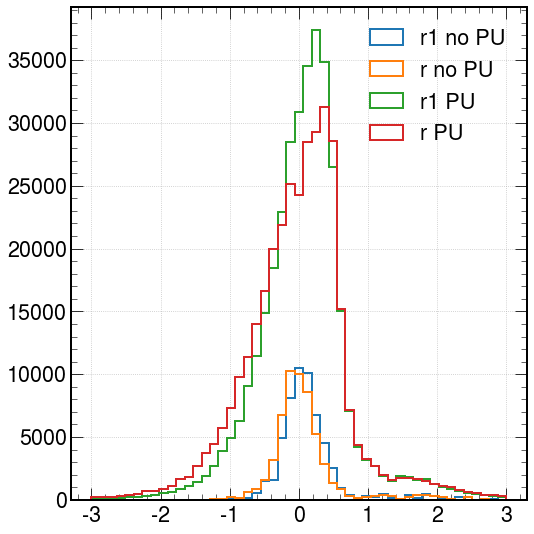

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

#train a linear discriminator to separate pileup from non-pileup jets
X=df[['r1','r2']].values
mask=(df['j1_matched']==0) | (df['j2_matched']==0)
clf = PCA(n_components=1)
clf.fit(X[mask])

print('Variance ratio',clf.explained_variance_ratio_)
print('Singular values',clf.singular_values_)
print('Components',clf.components_)

#add the result to the dataframe
df['r']=clf.transform(X).ravel()

#show the distributions
fig,ax=plt.subplots(figsize=(8,8))
bins=np.linspace(-3,3,50)
for l,m in [('no PU',mask),('PU',~mask)]:
    for v in ['r1','r']:
        plt.hist(df[m][v], weights=df[m]['lpt_wgt'],
                 label='{} {}'.format(v,l),histtype='step',bins=bins,linewidth=2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

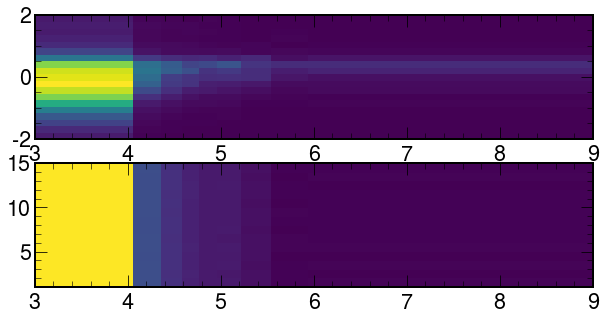

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
3.476314798247047


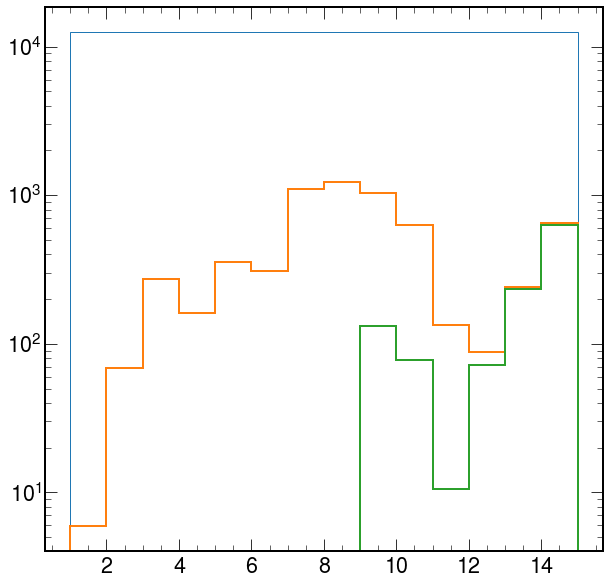

4.202075755266333


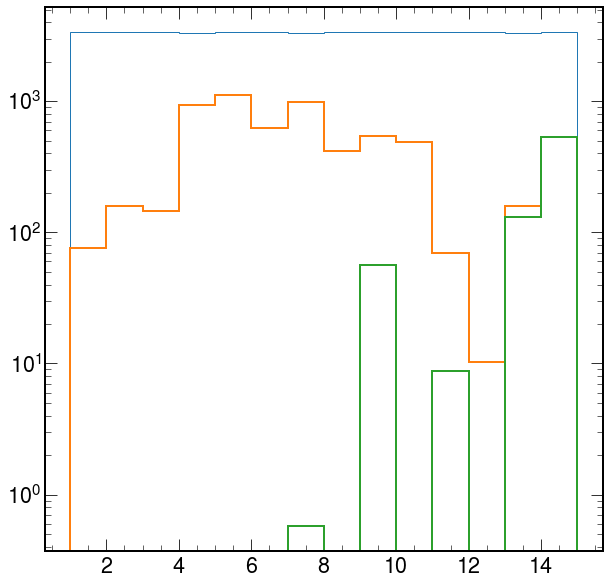

4.4691843258124715


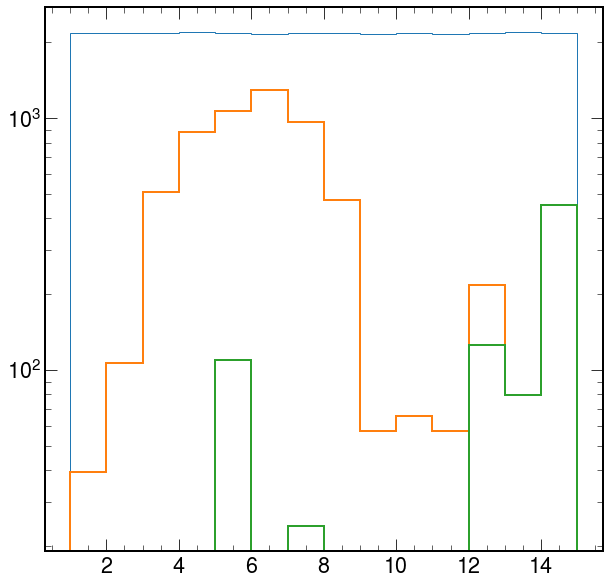

4.672138194593264


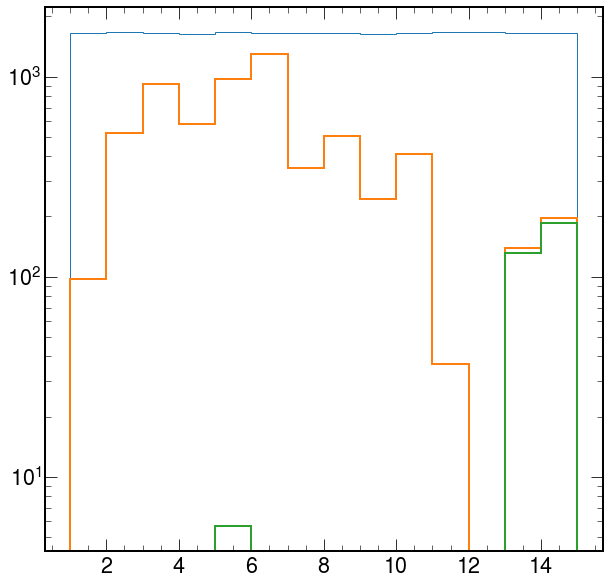

4.861017327013671


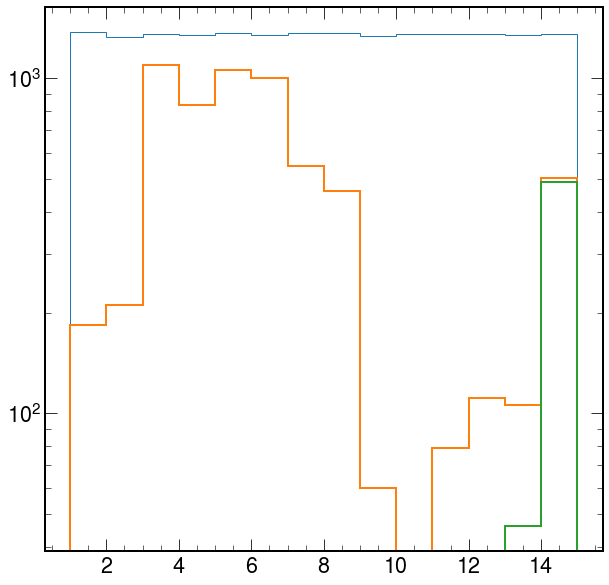

5.087289553366703


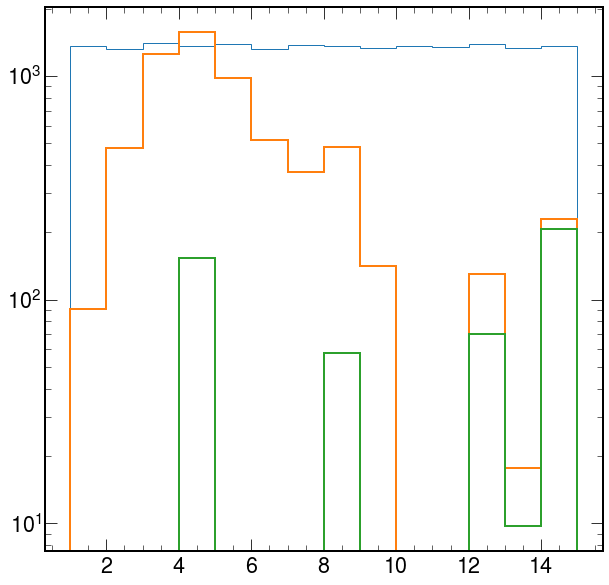

5.367882853403142


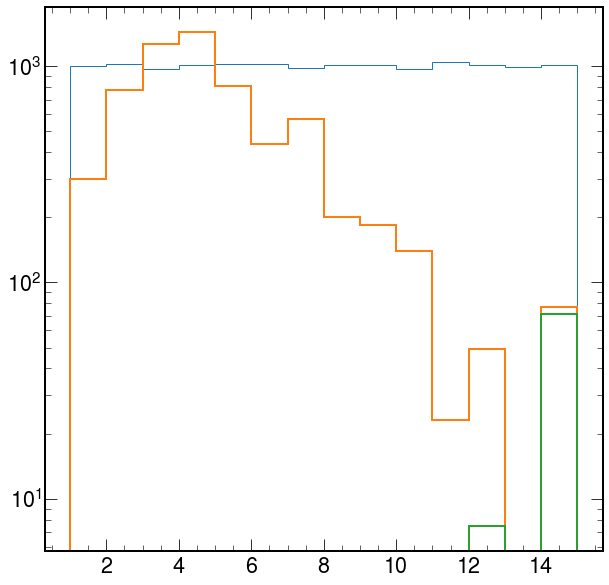

5.731759798728813


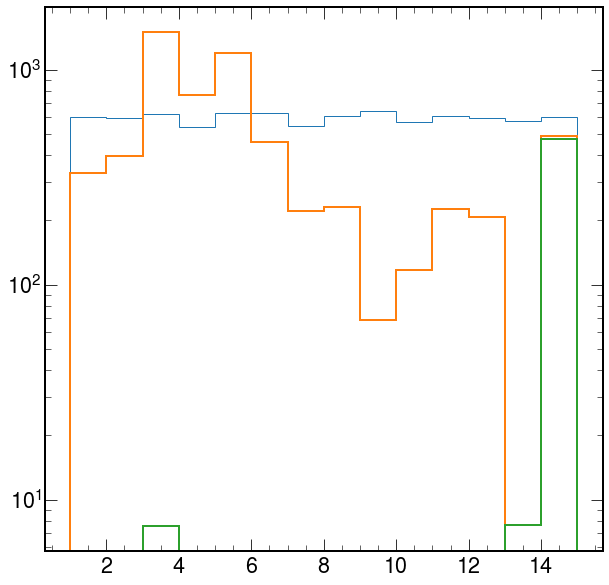

6.387587108647579


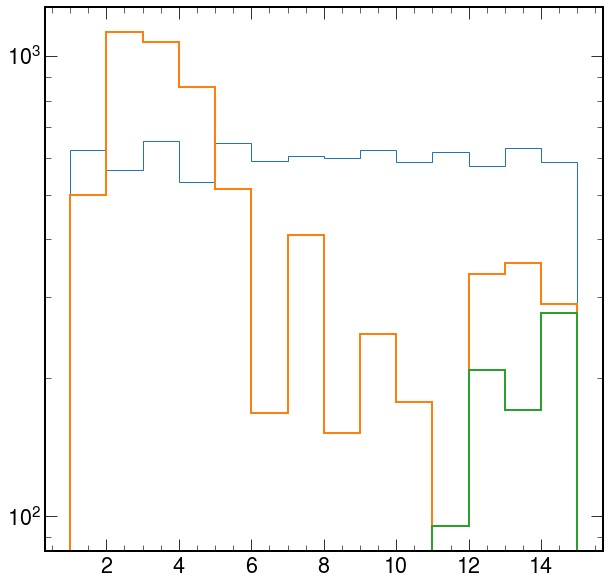

In [129]:
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

#find quantiles in delta Eta(jj) that sample equally pileup jets
#and assign as category
df['absdetajj']=np.abs(df['detajj'])
mask=(df['j1_matched']==1) & (df['j2_matched']==1) 
detajj_p=np.linspace(0.,1.0,10)
detajj_q = weighted_percentile(df[~mask]['absdetajj'].values, 
                               df[~mask]['lpt_wgt'].values, 
                               detajj_p)
detajj_q[0]=3
detajj_q[-1]=9
df['detajj_cat']=np.digitize(df['absdetajj'],detajj_q)  


#for each deltaEtajj category uniformize the R distribution for nonPU jets
#categorize the events in R categories such that for nonPU jets a uniform distribution is expected
nrq=15
r_p=np.linspace(0.,1,nrq)
df['r_cat']=-1
for detajj_cat in df['detajj_cat'].unique():
    
    detajj_mask=(df['detajj_cat']==detajj_cat)
    r_q = weighted_percentile(df[mask & detajj_mask]['r'].values,
                              df[mask & detajj_mask]['lpt_wgt'].values,
                              r_p)
    r_cat=np.digitize(df[detajj_mask]['r'],r_q)
    #df.loc[detajj_mask,'ddr'] = np.take(r_q,r_cat)
    df.loc[detajj_mask,'ddr']=r_cat
    

fig,ax=plt.subplots(2,1,figsize=(10,5))
ax[0].hist2d(df[mask]['absdetajj'],
             df[mask]['r'], 
             weights=df[mask]['lpt_wgt'],
             bins=(detajj_q,np.linspace(-2,2,20)))
ax[1].hist2d(df[mask]['absdetajj'],
             df[mask]['ddr'], 
             weights=df[mask]['lpt_wgt'],
             bins=(detajj_q,np.linspace(1,nrq,nrq)))
plt.show()
    
print(np.linspace(0,10,11))
mask_bothpu=(df['j1_matched']==0) #& (df['j2_matched']==0) 
for detajj_cat in sorted(list(df['detajj_cat'].unique())):  
    detajj_mask=(df['detajj_cat']==detajj_cat)
    print(df[detajj_mask]['absdetajj'].mean())
    #print(df[detajj_mask & ~mask][['r','r_cat']].describe())
    plt.hist(df[detajj_mask & mask]['ddr'],  weights=df[detajj_mask & mask]['lpt_wgt'],  bins=np.linspace(1,nrq,nrq),histtype='step')
    plt.hist(df[detajj_mask & ~mask]['ddr'], weights=df[detajj_mask & ~mask]['lpt_wgt'], bins=np.linspace(1,nrq,nrq), linewidth=2,histtype='step')
    plt.hist(df[detajj_mask & mask_bothpu]['ddr'], weights=df[detajj_mask & mask_bothpu]['lpt_wgt'], bins=np.linspace(1,nrq,nrq), linewidth=2,histtype='step')
    #plt.hist(df[detajj_mask & mask]['r'],weights=df[detajj_mask & mask]['lpt_wgt'],bins=np.linspace(-3,3,20))
    #plt.hist(df[detajj_mask & ~mask]['r'],weights=df[detajj_mask & ~mask]['lpt_wgt'],bins=np.linspace(-3,3,20),linewidth=2) 
    plt.yscale('log')
    plt.show()
    

In [ ]:
X = df[['r1','r2']]
mask=(df['j1_matched']==1) & (df['j2_matched']==1)
wgt= df['lpt_wgt']

pca = PCA(n_components=1)
mask_pca=(df['j1_matched']==0) | (df['j2_matched']==0)
df['r'] = pca.fit(X[mask_pca]).transform(X).ravel()
print('Components:',pca.components_)
print('sing. values:',pca.singular_values_)
print('Variance:',pca.explained_variance_)

#df['r']=df['r1']
#
res_df['detajj_cat']=np.digitize(res_df['detajj'],detajj_q)    
res_df.set_index(['detajj_cat'],inplace=True)
q50=res_df.groupby(level=[0]).quantile(0.5)
q84=res_df.groupby(level=[0]).quantile(0.84)
q16=res_df.groupby(level=[0]).quantile(0.16)

from scipy.interpolate import UnivariateSpline
spl_50 = UnivariateSpline(q50['detajj'].values, q50['r'].values, k=3, ext=0)   
spl_84 = UnivariateSpline(q84['detajj'].values, q84['r'].values, k=3, ext=0)   
spl_16 = UnivariateSpline(q16['detajj'].values, q16['r'].values, k=3, ext=0)   


nq=21
deta_mask=np.abs(df['detajj'])>4
q_r = weighted_percentile(df[mask]['r'].values, wgt[mask].values, np.linspace(0,1,nq))
absdeta=np.abs(df['detajj'])
df['ddr'] = (df['r'] -spl_50(absdeta)) / (0.5*(spl_84(absdeta)-spl_16(absdeta)))

detajj_mask=(absdeta>5.)

plt.figure()
bins=np.linspace(0,nq,nq)
bins=np.linspace(-2,2,20)
plt.hist(df[~detajj_mask & mask]['r'], histtype='step', label='no PU<4', bins=bins, weights=wgt[~detajj_mask & mask])
plt.hist(df[detajj_mask & mask]['r'], histtype='step', label='no PU>4', bins=bins, weights=wgt[detajj_mask & mask])
plt.hist(df[~detajj_mask & ~mask]['r'], histtype='step', label='PU<4', bins=bins, weights=wgt[~detajj_mask & ~mask],linewidth=3)
plt.hist(df[detajj_mask & ~mask]['r'], histtype='step', label='PU>4', bins=bins, weights=wgt[detajj_mask & ~mask],linewidth=3)
plt.legend(loc='best')
plt.show()


plt.figure()
plt.hist2d(np.abs(df[mask]['detajj']),df[mask]['r'], weights=wgt[mask],bins=([3,4,5,6],np.linspace(-2,2,100)))
xs=np.linspace(3,7,10)
for q in np.linspace(0.1,0.9,9):
    qvals=res_df.groupby(level=[0]).quantile(q)
    plt.scatter(qvals['detajj'],qvals['r'],color='black')
    spl=UnivariateSpline(qvals['detajj'].values, qvals['r'].values, k=3, ext=0)   
    plt.plot(xs,spl(xs))
plt.show()


plt.figure()
bins=np.linspace(0,nq,nq)
bins=np.linspace(-1.5,1.5,20)
plt.hist(df[~detajj_mask & mask]['ddr'], histtype='step', label='no PU<4', bins=bins, weights=wgt[~detajj_mask & mask])
plt.hist(df[detajj_mask & mask]['ddr'], histtype='step', label='no PU>4', bins=bins, weights=wgt[detajj_mask & mask])
plt.hist(df[~detajj_mask & ~mask]['ddr'], histtype='step', label='PU<4', bins=bins, weights=wgt[~detajj_mask & ~mask],linewidth=3)
plt.hist(df[detajj_mask & ~mask]['ddr'], histtype='step', label='PU>4', bins=bins, weights=wgt[detajj_mask & ~mask],linewidth=3)
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors

nsample=10000 #target number of events in mixed sample, we'll retrieve 3x 2j events for mixing

mixdir='{}/pumix'.format(_dataframesdir)
os.system('mkdir -p {}'.format(mixdir))

print('Preparing mixing bank')
for proc,isData in [#('data',True),
                     ('gjetslo',False),
                    ]:

    print('[{}]'.format(proc))
    
    #preselect 2j events and store info on the jets
    df=pd.read_hdf(os.path.join(_dataframesdir,'{}.h5'.format(proc)),key='data')
    mask=((df['Pass_lpt']>0) | (df['Pass_hpt']>0)) & (df['idcode']>=256) & (df['nj']>1)
        
    #columns of interest for the mixing bank
    cols=[x+y for x,y in itertools.product(['pt','eta','phi','m','a','qgl','puid'],['j1','j2'])]
    cols+=['Pass_lpt','Pass_hpt','pt','phi']
    if not isData:
        cols+=['lpt_wgt','hpt_wgt']
    
    #select and copy
    mixbank_df = df[mask][cols].sample(min(mask.sum(),3*nsample))
    mixbank_df.reset_index(inplace=True)
    
    #build a kNN to evaluate the distance in phase space of the events to mix
    #def deltaPhi(phi1,phi2):
    #    dphi=phi1-phi2
    #    dphi=np.where(dphi>2*np.pi,dphi-2*np.pi,dphi)
    #    dphi=np.where(dphi<0,dphi+2*np.pi,dphi)
    #    return dphi
    #def getR(pt,phi,ptj,phij):
    #    dphi=deltaPhi(phi,phij)
    #    return 1.+(ptj/pt)*np.cos(dphi)
    mixbank_df['r1']=mixbank_df['ptj1']/mixbank_df['pt'] # getR(mixbank_df['pt'],mixbank_df['phi'],mixbank_df['ptj1'],mixbank_df['phij1'])
    knn_vars=['Pass_lpt','Pass_hpt','pt','phi','ptj1','phij1','etaj1','r1']
    knn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(mixbank_df[knn_vars])
    
    del df
    print('\tSelected {} events in {} for jet mixing'.format(mixbank_df.shape[0],proc))
    
        
    #apply mixing on one jet events    
    df=pd.read_hdf(os.path.join(_dataframesdir,'{}_1j.h5'.format(proc)),key='data')   
    mask_1j=((df['Pass_lpt']>0) | (df['Pass_hpt']>0)) & (df['idcode']>=256) & (df['nj']==1)
    df=df[mask_1j].sample(min(mask_1j.sum(),nsample))
    df.reset_index(inplace=True)
    df['r1']=df['ptj1']/df['pt']
    #df['r1']=getR(df['pt'],df['phi'],df['ptj1'],df['phij1'])
    
    #evaluate the distances in the variables to match and get the ranked event to mix 
    ranked_idx=knn.kneighbors(df[knn_vars], 1, return_distance=False).reshape(-1)    
    ranked_distance=knn.kneighbors(df[knn_vars], 1, return_distance=True)[0].reshape(-1) 
    print('\tCreating mixed dataset for 2nd jet with {} events'.format(df.shape[0]))
    mix_cols=['ptj2','etaj2','phij2','mj2','aj2','qglj2','puidj2']
    df['idx']=df.index

    def getFromMixingBank(idx):
        mix_idx=ranked_idx[ idx ]
        wgt=1./(ranked_distance[idx]+1e-3)
        x=mixbank_df.iloc[mix_idx][mix_cols].tolist()
        return [wgt]+x
    df['mixwgt'], df['ptj2'], df['etaj2'], df['phij2'], df['mj2'], df['aj2'],  df['qglj2'], df['puidj2'] = zip( * df['idx'].apply(getFromMixingBank) )
    df['j2_matched']=-2
    df['nj']=2
    outf=os.path.join(_dataframesdir,'{}_j2mix.h5'.format(proc))
    df.to_hdf(outf,key='data')
    print('\tSaved the j2 mixed {} events in {}'.format(proc,outf))
        
    del mixbank_df
    del df

In [ ]:
df=pd.read_hdf('/eos/user/p/psilva/data/ewk-vjj/tight/DataFrames/2018/gjetslo_j2mix.h5')
bins=np.linspace(0,2,50)

mask=(df['Pass_lpt']>0) & (df['Pass_hpt']==0)
plt.hist(df[mask]['ptj2']/df[mask]['pt'],weights=df[mask]['mixwgt'],bins=bins,density=True,histtype='step',label='dd')

df_true=pd.read_hdf('/eos/user/p/psilva/data/ewk-vjj/tight/DataFrames/2018/gjetslo.h5')
mask=(df_true['Pass_lpt']>0) & (df_true['Pass_hpt']==0) & (df_true['j2_matched']==0)
plt.hist(df_true[mask]['ptj2']/df_true[mask]['pt'],bins=bins,density=True,histtype='step',label='MC')

plt.grid()
plt.legend()
plt.show()

## 1. Contamination from pileup jets

It is somehow expected that at lower photon $p_{T}$, higher $\Delta\eta(jj)$ and $m_{jj}$, forward jets from pileup contribute with more relevance.
Unfortunately that's where the signal lies so one needs to have a reliable estimate of this contribution.
At higher photon $p_{T}$ the contribution from pileup jets is less relevant.

In [ ]:

#load histograms
# g+jets and signal : all components with a prompt photon
# nonmprompt : databased
# ggjets: prompt only
samples = ['gjetslo_prompt','gjetslo_promptpujet','gjetslo_promptpujet2','gjetslo_allprompt',  
           'ewgjjhw_prompt','ewgjjhw_promptpujet','ewgjjhw_promptpujet2','ewgjjhw_allprompt',  
           'data_databased_nonprompt',
           'ggjets_prompt',
           'data']
histos={}
for s in samples:
    with open('{}/{}.pck'.format(_histdir,s),'rb') as fin:
        histos[s]=pickle.load(fin)
print('Histos available for',histos.keys())

In [ ]:
def comparePUJetsContribution(cat='hpt',var='detajj',proc='gjetslo',sig='ewgjjhw') :
    
    h     = histos['{}_prompt'.format(proc)]['{}_{}'.format(cat,var)]
    hsig  = histos['{}_prompt'.format(sig)]['{}_{}'.format(cat,var)]
    hpu   = histos['{}_promptpujet'.format(proc)]['{}_{}'.format(cat,var)]

    ratio  = hpu['histo'][1]/h['histo'][1]
    hratio = ( h['histo'][0], 
              ratio,
              ratio*np.sqrt( (hpu['histo'][2]/hpu['histo'][1])**2 + (h['histo'][2]/h['histo'][1])**2  )
             )
    
    ratio_sig=hsig['histo'][1]/h['histo'][1]
    hratio_sig = ( h['histo'][0], 
                   ratio_sig,
                   ratio*np.sqrt( (hsig['histo'][2]/hsig['histo'][1])**2 + (h['histo'][2]/h['histo'][1])**2  )
                 )
    showComparisonPlot(overlay=[hpu['histo'],h['histo'],hsig['histo']],
                       overlay_labels=[r'$\geq$ 1 PU jet',r'Prompt $\gamma$',r'EW$\gamma$jj'],
                       overlay_bottom = [hratio,hratio_sig],
                       overlay_bottom_labels = ['PU/Prompt',r'EW$\gamma$jj/Prompt'],
                       rylabel='Ratio',
                       logy=True, logx=False,
                       xlabel=h['xlabel'], ylabel='Events',
                       yran=(1,None),
                       ryran=(0.,0.5),
                       ptitle='{} {} ({})'.format(_samplesTitles[proc], h['label'],_year),
                       outname=os.path.join(_plotsdir,'{}_{}_{}_pujets_{}'.format(cat,var,proc,_year)))

for cat,var in itertools.product(['lpt','hpt'],['detajj','mjj'] ):       
    comparePUJetsContribution(cat,var,proc='gjetslo',sig='ewgjjhw')

## 2. Individual jet balancing distributions

Below we do an inspection of the $R_j = 1 + \vec{p}_{T}(j)\cdot \vec{p}_{T}(\gamma) /  |p_T(\gamma)|^2$ variables.

In [ ]:
for cat in ['lpt','hpt']:
    for s in ['gjetslo_promptpujet','gjetslo_allprompt','ewgjjhw_allprompt']:
        
        title=_samplesTitles[s.split('_')[0]]
        
        jet_sel='=0 PU jets'
        if 'pujet' in s: jet_sel='$\geq$1 PU jet'

        h=histos[s]['{}_r1vsr2'.format(cat)]
        show2DHistogram( histo=h['histo'],
                         xlabel=h['xlabel'], ylabel=h['ylabel'],
                         ptitle='{} ({})'.format(h['label'],_year),
                         extra_txt=[title,jet_sel])
                         #outname=os.path.join(_plotsdir,'{}_{}_r1vsr2_{}'.format(cat,s,_year)) )

In [ ]:
for cat in ['lpt','hpt']:
    for var in ['r1','r2']:

        pu=histos['gjetslo_promptpujet']['{}_{}'.format(cat,var)]
        pu2=histos['gjetslo_promptpujet2']['{}_{}'.format(cat,var)]

        nopu = histos['gjetslo_allprompt']['{}_{}'.format(cat,var)]
        sig  = histos['ewgjjhw_allprompt']['{}_{}'.format(cat,var)]
    
        h_list     = [pu['histo'], pu2['histo'], nopu['histo']] #, sig['histo']]
        label_list = [r"$\geq$1 PU jet", "PU jet 2",  "no PU jets"] #,r"EW$\gamma$jj"]
        
        showHistogram(h_list, label_list,
                      xlabel=pu['xlabel'], ylabel='Events',
                      ptitle='{} ({})'.format(pu['label'],_year),
                      logy=True, yran=(1,None),
                      outname=os.path.join(_plotsdir,'{}_{}_comparison_{}'.format(cat,var,_year)) )

In [ ]:
from scipy.stats import crystalball
from scipy.stats import moyal,norm
from scipy.special import eval_chebyt

def resp_func(x,k,loc,scale,beta,m,a,b,c):
    """pileup response function"""
    c1=k*crystalball.pdf(x, beta, m, loc, scale)    
    c2=np.where(x>0.,a*eval_chebyt(2,x)+b*eval_chebyt(1,x)+c*eval_chebyt(0,x),0.)
    return c1+c2

#def resp_func(x,k,beta,m,loc,scale):
#    """pileup response function""" 
#    c1=k*crystalball.pdf(x, beta, m, loc, scale)  
#    return c1



def prepareJetBalanceTemplates(cat='lpt',sample='gjetslo_promptpujet1',isPU=False):

    """uses the 2D r1 vs detajj histograms compares the different slices"""
      
    #normalize inclusive distribution
    prof  = histos[sample]['{}_r1vsdetajj'.format(cat)]

    (xbins,ybins),inc,inc_unc = prof['histo']
    ntot        = np.sum(inc)
    inc         = np.sum(inc,axis=0)/ntot
    inc_unc     = np.sqrt(np.sum(inc_unc**2,axis=0))/ntot
    inc=[ybins,inc,inc_unc]

    #pileup jets have low statistics: approximate with parameterization
    if isPU:
        ycen=0.5*(ybins[0:-1]+ybins[1:])
        mask=np.where(inc[1]>0)
        popt, pcov = curve_fit(resp_func, ycen[mask], inc[1][mask], sigma=inc[2][mask],
                               #bounds=((0,-0.2,1e-3,1e-3,1.001),
                               #        (10,0.2, 0.2, 5., 10.)),
                               bounds=((0,-0.2,1e-3,1e-3,1.001, -np.inf,-np.inf,-np.inf ),
                                       (10,0.2, 0.2, 5., 10.,    0,     np.inf,np.inf)) 
                              )
        print(cat,sample,popt)
        stack=[ (ybins, resp_func(ycen,*popt), np.zeros_like(ycen) )  ]
        stack_labels=['CB+Polynomial']
    else:
        stack=None
        stack_labels=None
        
    xlabel = histos[s]['{}_r1'.format(cat)]['xlabel']
    label  = histos[s]['{}_r1'.format(cat)]['label']
    
    #project detajj slices
    nxbins = len(xbins)-1    
    slices,slice_labels=[],[]
    raw_slices=[]
    raw_yields=[]
    ry_slices=[]
    for i in range(nxbins):

        #skip if no counts
        h_i     = prof['histo'][1][i,:]
        raw_slices.append( np.array(h_i) )
        ntot    = np.sum(h_i)
        raw_yields.append(ntot)
        if ntot==0 : continue
            
        h_i     = h_i/ntot
        h_unc_i = prof['histo'][2][i,:]
        h_unc_i = h_unc_i/ntot
        slices.append( (ybins, h_i, h_unc_i) )
  
        detajj_ran = xbins[i:i+2]    
        slice_labels.append( r'{:3.0f}<$|\Delta\eta(jj)|$<{:3.0f}'.format(*detajj_ran) )

        #compute the ratio to the inclusive distribution
        if isPU:
            r=h_i/stack[0][1]
            r_unc=h_unc_i/stack[0][1]
            ry_slices.append( (ybins, r, r_unc) )
        else:
            r=h_i/inc[1]
            r_unc=np.zeros_like(r) #h_unc_i/inc[1]
            ry_slices.append( (ybins, r, r_unc) )
    
    rylabel='Exp./Model' if isPU else 'Slice/Inc.'
    
    showComparisonPlot(stack=stack,    stack_labels=stack_labels,
                       data=inc,       data_label='Inclusive',
                       overlay=slices, overlay_labels=slice_labels,
                       overlay_bottom=ry_slices, overlay_bottom_labels=None,
                       logy=True,     logx=False,
                       xlabel=xlabel,  ylabel='PDF', rylabel=rylabel,
                       ryran=(0.,2.), yran=(1e-3,1),
                       ptitle='{} ({})'.format(label,_year),
                       legendFontSize=16,
                       outname=os.path.join(_plotsdir,'puslices_{}_{}_{}'.format(cat,sample,_year)))
    if isPU:        
        shapes=np.tile(stack[0][1],(nxbins,1))
        yields=np.array(raw_yields)
        return (shapes.T*yields).T
    else:
        return np.array(raw_slices)

    
#loop over the different samples to prepare the templates dictionary for the fit
templates_dict={'lpt':{},'hpt':{}}   
for cat in ['lpt','hpt']:
    for sample,isPU,isData,isResidual in [ ('data',                False,  True,  False),
                                           ('gjetslo_promptpujet', True,   False, False),
                                           #('gjetslo_promptpujet2',True,   False, False),
                                           ('gjetslo_allprompt',   False,  False, False),
                                           ('ggjets_prompt',       False,  False, True),
                                           ('ewgjjhw_prompt',      False,  False, True) ]:
    
        res=prepareJetBalanceTemplates(cat,sample,isPU)

        #ad the template to the final component
        key='data'
        if not isData:
            if isPU         : key='pu'
            elif isResidual : key='others'
            else            : key='prompt'
        if not key in templates_dict[cat]:
            templates_dict[cat][key]=np.array(res)
        else:
            templates_dict[cat][key]+=res
            
    templates_dict[cat]['profile']=histos[s]['{}_detaprofile'.format(cat)]['histo'][1]

#save the templates in a pickle file
with open(os.path.join(_histdir,'pujets_templates.pck'),'wb') as fout:
    pickle.dump(templates_dict,fout,pickle.HIGHEST_PROTOCOL)

In [ ]:
#start the template fitter to extract the pileup jet scaling component
pujf=PUJetsFitter(_histdir,verbose=True)
pois={}
for cat in ['lpt','hpt']:

    templates_url='{}/pujets_templates.pck'.format(_histdir)
    with open(templates_url,'rb') as fin:
        templates=pickle.load(fin)[cat]
                            
    fitName='fit_pujets_{}_{}'.format(cat,_year)
    ws_url=pujf.runFit(hists_dict=templates,fitName=fitName)

    outname=os.path.join(_plotsdir,fitName)
    title='Low p_{T}' if cat=='lpt' else 'High p_{T}'
    title += '({})'.format(_year)
    pujf.showFitResult(ws_url,title,outname)
    pois[cat]=pujf.getPOIs(ws_url)

In [ ]:
import pprint
pprint.pprint(pois)